# Forecasting
t<sub>0</sub> corresponds to the time at which the forecast is made (12:00 CET) for EPEX SPOT day-ahead auction.<br>

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from utils import tools, preprocessing, models, eval, plotting, hpo

2025-05-15 15:21:51.283869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747315311.305743 3447662 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747315311.313094 3447662 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-15 15:21:53,996	INFO util.py:154 -- Outdated packages:
  ipywidgets==6.0.0 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 1.3.5
Numpy version: 1.21.5
Tensorflow version: 2.18.0


In [3]:
config = tools.load_config('config.yaml')

In [4]:
# paths
data = 'pvod'
key = 'station06.csv'

# model params
model_name = 'tcn-gru'
output_dim = 48 # in hours
make_callbacks = False
strategy = 'fedadam'

# data params
freq = '1h'
lookback = 48 # in hours
horizon = 48 # in hours
# data split params
t_0 = 12 # epex spot auction time (12:00 CET)
scale_y = False
lag_in_col = False

# more params
evaluate_on_all_test_data = True
study_name = f'fl_a-{strategy}_d-{data}_m-{model_name}_out-{output_dim}_freq-{freq}'

In [5]:
# config related
config['data']['freq'] = freq
config['model']['name'] = model_name
config['model']['output_dim'] = output_dim
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon
config = tools.handle_freq(config=config)
freq = config['data']['freq']
output_dim = config['model']['output_dim']
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon

In [6]:
# read data
#df = preprocessing.preprocess_1b_trina(path=path,
#                                       freq=freq)
known, observed, static = preprocessing.get_features(data=data)
real_features = known + observed
dfs = preprocessing.get_data(data=data, data_dir='../Data', freq=freq, rel_features=real_features)
df = dfs[key]

In [7]:
prepared_data, df = preprocessing.pipeline(data=df,
                                           config=config,
                                           known_cols=known,
                                           observed_cols=observed,
                                           static_cols=static,
                                           test_start=pd.Timestamp(config['data']['test_start']))
X_train, y_train = prepared_data['X_train'], prepared_data['y_train'],
X_test, y_test = prepared_data['X_test'], prepared_data['y_test']
index_train = prepared_data['index_train']
index_test = prepared_data['index_test']
scaler_y = prepared_data['scalers']['y']
#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8040 entries, 2018-07-13 16:00:00 to 2019-06-13 15:00:00
Freq: H
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   nwp_gti                 8040 non-null   float64
 1   nwp_temperature         8040 non-null   float64
 2   nwp_humidity            8040 non-null   float64
 3   nwp_windspeed           8040 non-null   float64
 4   power                   8040 non-null   float64
 5   lmd_gti_lag_48          7992 non-null   float64
 6   lmd_temperature_lag_48  7992 non-null   float64
 7   lmd_windspeed_lag_48    7992 non-null   float64
 8   power_lag_48            7992 non-null   float64
dtypes: float64(9)
memory usage: 628.1 KB


In [9]:
config['model']['fl'] = True
study = hpo.load_study(config['hpo']['studies_path'], study_name)
hyperparameters = hpo.get_hyperparameters(config=config, study=study)
hyperparameters['epochs'] = 100#config['model']['epochs']

config['model']['name'] = model_name

config['model']['feature_dim'] = tools.get_feature_dim(X_train)
model = models.get_model(config=config,
                         hyperparameters=hyperparameters)

I0000 00:00:1747315321.763777 3447662 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46159 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1747315321.766802 3447662 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46463 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6
I0000 00:00:1747315321.769550 3447662 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46463 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6
I0000 00:00:1747315321.772168 3447662 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46463 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:61:00.0, compute capability: 8.6
I0000 00:00:1747315321.774846 3447662 gpu_device.cc:2022] Created device /job:localh

In [10]:
#model.summary()

In [11]:
if make_callbacks:
    callbacks = [keras.callbacks.ModelCheckpoint('models/best.keras', save_best_only=True)]

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = hyperparameters['batch_size'],
    epochs = hyperparameters['epochs'],
    verbose = 'auto',
    callbacks = callbacks if make_callbacks else None,
    validation_data=(X_test, y_test),
    shuffle = hyperparameters['shuffle']
)
if make_callbacks:
    model = keras.models.load_model('models/best.keras')
best_epoch = np.argmin(history.history['val_loss']) + 1

Epoch 1/100


I0000 00:00:1747315325.982332 3456557 cuda_dnn.cc:529] Loaded cuDNN version 90701


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0409 - mae: 0.1403 - rmse: 0.1964 - val_loss: 0.0427 - val_mae: 0.1381 - val_rmse: 0.2066
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0238 - mae: 0.1066 - rmse: 0.1498 - val_loss: 0.0460 - val_mae: 0.1375 - val_rmse: 0.2144
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0253 - mae: 0.1057 - rmse: 0.1545 - val_loss: 0.0397 - val_mae: 0.1322 - val_rmse: 0.1993
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0199 - mae: 0.0943 - rmse: 0.1370 - val_loss: 0.0359 - val_mae: 0.1320 - val_rmse: 0.1894
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0182 - mae: 0.0921 - rmse: 0.1304 - val_loss: 0.0340 - val_mae: 0.1288 - val_rmse: 0.1845
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0169 - mae: 0.0865 - rmse: 0.1257 - val_loss: 0.0287 - val_mae: 0.1220 - val_rmse: 0.1695
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0150 - mae: 0.0829 - rmse: 0.1189 - va

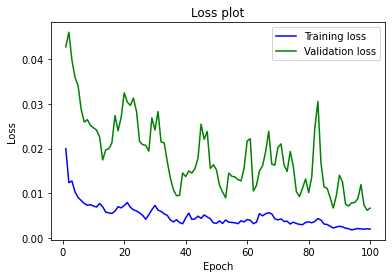

In [12]:
plotting.plot_training(history=history,
                       validation=True,
                       save_name=None)

In [13]:
y_true, y_pred = tools.get_y(X_test=X_test,
                             y_test=y_test,
                             scaler_y=scaler_y,
                             model=model)
df_pred = tools.y_to_df(y=y_pred,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)
df_true = tools.y_to_df(y=y_true,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)

y_pers = eval.persistence(y=df['power'],
                    horizon=horizon,
                    from_date=str(index_test[0].date()))
y_pers = preprocessing.make_windows(data=y_pers,
                                    seq_len=y_pred.shape[-1])
df_pers = tools.y_to_df(y=y_pers,
                    output_dim=output_dim,
                    horizon=horizon,
                    index_test=index_test,
                    t_0=None if evaluate_on_all_test_data else t_0)

pers = {}
pers['Persistence'] = df_pers

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [14]:
results = eval.evaluate_models(pred=df_pred,
                               true=df_true,
                               persistence=pers,
                               main_model_name=model_name)

In [15]:
results

,R^2,RMSE,MAE,Skill
Models,,,,
tcn-gru,0.854029,0.079489,0.047639,0.215208
Persistence,0.762995,0.101287,0.048066,0.000000


R^2: 0.4420471948558734
RMSE: 0.1517225726833726
MAE: 0.10039462212453353


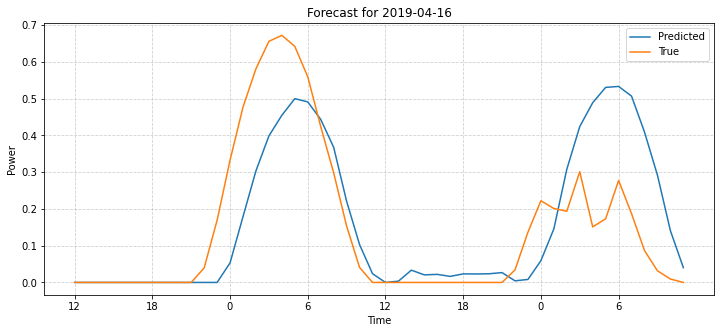

In [16]:
#date = '2018-06-06'
date = plotting.random_date(start_date=str(index_test[0].date()),
                            end_date=str(df.index[-1].date()))

plotting.plot_forecast(pred=df_pred,
                       true=df_true,
                       date=date,
                       horizon=horizon,
                       t_0=t_0,
                       figsize=(12,5),
                       print_metric=True,
                       grid=True)

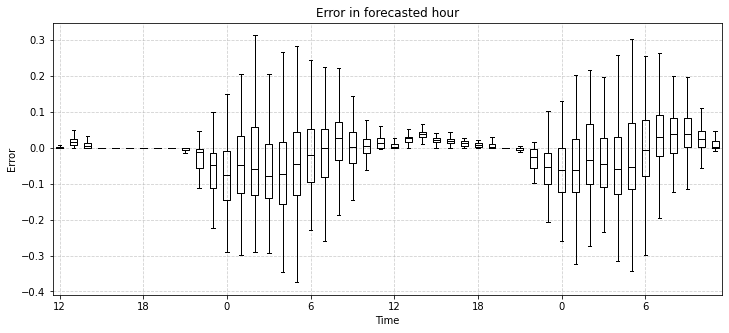

In [17]:
plotting.plot_boxplots(pred=df_pred,
                       true=df_true,
                       t_0=t_0,
                       horizon=horizon,
                       figsize=(12,5),
                       showfliers=False,
                       grid=True)

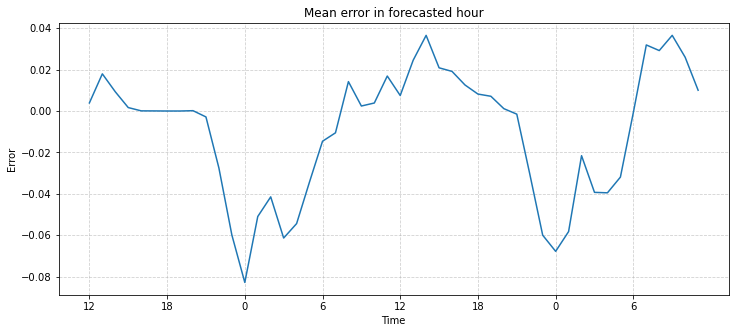

In [18]:
plotting.plot_error(pred=df_pred,
                    true=df_true,
                    t_0=t_0,
                    horizon=horizon,
                    figsize=(12,5),
                    grid=True)

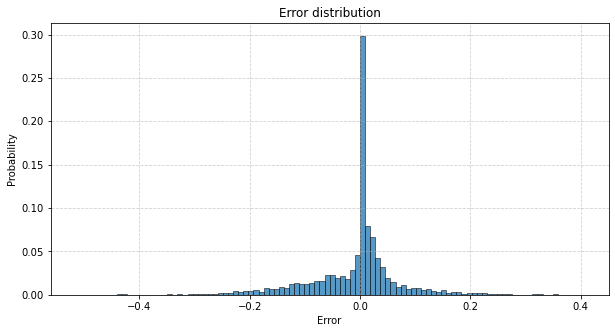

In [19]:
plotting.plot_error_distribution(pred=df_pred,
                                 true=df_true,
                                 figsize=(10,5),
                                 bins=100,
                                 t_0=t_0,
                                 grid=True)